**Standardization and k-NN**

In this unit, we will fit k-NN to the heart disease data. But before that, let’s first discuss the required preprocessing steps and do a quick refresher about standardization.

We know that standardization is needed in many situations. For instance, we saw that gradient descent underperforms or even diverges when features have different scales, or that it’s recommended to standardize data before applying regularization. But what about k-NN?

First, k-NN doesn’t learn parameters from the training set. Its k value is a hyperparameter set before fitting the algorithm. Hence, it doesn’t use an optimizer like gradient descent. However, we need to be careful about the features scale because it uses a distance metric to find the nearest neighbors. In the case of the weight and height, the weight variable has a much larger scale than height. For this reason, we need to be careful: k-nearest neighbors searches for points with similar values. Since the weight values are more spread out, k-NN will favor points with similar weight values.

It’s important to note that standardizing the data doesn’t modify the information content: we can still observe the relationship between height and weight i.e. taller people weigh more.

As you can see, the 100 points from the previous experiment in orange now form an ellipse with the weight variable as the minor axis. This reveals the bias of k-NN toward similar weight values.

**When to apply standardization?**

In practice, we standardize the input data for two reasons

* Some optimization algorithms work better when the features are standardized ex. gradient descent
* Some algorithms are sensitive to the scale of the features because they use a distance metric ex. k-NN
* With regularization which expects features to be on the same scale

**In most cases, it’s a good idea to standardize the features when using k-NN to avoid having a model that is biased toward features that have a larger scale.**

However we need to remember that by standardizing the data we transform the feature space and in some cases this transformation might produce undesired results. For instance, in the first example that we saw with the house prices from the “K-nearest neighbors” introductory unit, each data point is represented by its location on a longitude/latitude grid. But the data points (the houses) might be more spread out along the longitude or the latitude axis. (Long Beach (NY, USA) or the African state The Gambia are examples of this.) So in this case, we don’t want to rescale these two features individually, but with the same scaler. In other scenarios features may be representing different prices or the time intervals measured by different sensors. It depends on the particular context and our judgment whether we think that the relative relationship of these feature values is important and standardizing them risks distortion when using k-NN. **In any case, it’s a good idea to try with and without standardization to see what works best.**

**KNeighborsClassifier**
Let’s see if we can improve our baseline with k-NN. First, let’s take a look at the features scale

In [1]:
import pandas as pd

# Load data
data_df = pd.read_csv("c4_heart-numerical.csv")

# Data summary
data_df.describe()


,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604,0.663366
std,9.038662,17.599748,51.776918,22.875003,1.161075,0.934375
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,275.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,3.000000


The features have different scales, so we will add a StandardScaler step in our classification pipeline. But, let’s first split the data



In [2]:
from sklearn.model_selection import train_test_split

# Create X/y arrays
X = data_df.drop("disease", axis=1).values
y = data_df.disease.values

# Split data
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

We can now create a pipeline object with k-NN. Scikit-learn implements a KNeighborsRegressor and a KNeighborsClassifier estimator. We can set the number of neighbors with their n_neighbors attribute.

Let’s try with the default value of 5

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a k-NN pipeline
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 0.747


The accuracy is already a lot better than the “most frequent” baseline from the previous unit: 75% vs. 52%.

As a small experiment, let’s see what happens if we remove the scaler

In [4]:
from sklearn.base import clone

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler=None)
knn_pipe2.fit(X_tr, y_tr)
print("Accuracy: {:.3f}".format(knn_pipe2.score(X_te, y_te)))

Accuracy: 0.670


**Removing standardization hurts accuracy which drops to 67%.**

Tuning k with grid search
Finally, let’s see if we can improve the results by tuning k. There is around 200 data points in the training set - to get a good overview of the effect of k, let’s generate a set of candidate values between 1 and 100 by steps of 5

In [5]:
import numpy as np

# Generate a set of k values
k_values = np.r_[1, np.arange(5, 101, step=5)]
k_values

array([  1,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100])

In [6]:
#We can now run grid search using set_params() and a for loop

# [Code adapted from the previous course]
# Variable to store the results
gs_results = []

# Grid search
for k in k_values:
    # Fit k-NN model
    knn_pipe.set_params(knn__n_neighbors=k)
    knn_pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "k": k,
            "train_accuracy": knn_pipe.score(X_tr, y_tr),
            "test_accuracy": knn_pipe.score(X_te, y_te),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="test_accuracy", ascending=False).head()

,k,train_accuracy,test_accuracy
8,40,0.740566,0.780220
4,20,0.754717,0.780220
7,35,0.768868,0.780220
3,15,0.768868,0.769231
5,25,0.768868,0.769231


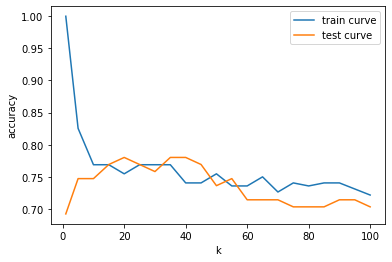

In [7]:
#The optimal k values seems to be between 20 and 40. To get a better overview, let’s plot the validation curves

%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["k"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["k"], gs_results["test_accuracy"], label="test curve")
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()

Average several runs

There is no clear pattern for k between 20 and 40 in the results from above. Let’s see if we can get more stable results by averaging the scores over 30 runs



In [8]:
# Run several times the evaluation
gs_results = []
for run_idx in range(30):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "test_accuracy": knn_pipe.score(X_te, y_te),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

gs_results contains 30 scores for each k value. Let’s group the results and compute the average scores



In [9]:
# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

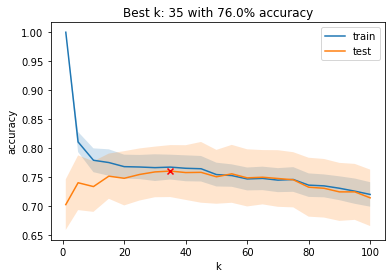

In [10]:
##We can now plot the average validation curves

# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_te, label="test")

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te - std_te, mean_te + std_te, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_te[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()


The best k value is around 35 with a mean accuracy of 76% and a standard deviation around 4%.

As a small experiment, we can compare the results without standardization by adding scaler=None to the knn_pipe.set_params() call in the for loop

In [11]:
knn_pipe.set_params(scaler=None, knn__n_neighbors=k)

Pipeline(steps=[('scaler', None),
                ('knn', KNeighborsClassifier(n_neighbors=100))])

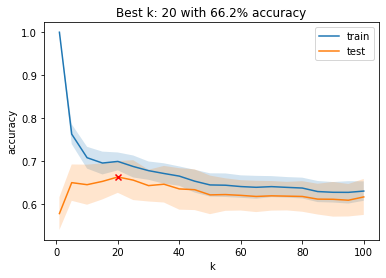

In [12]:
# Run several times the evaluation
gs_results = []
for run_idx in range(30):
    # Split into train/test sets
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=run_idx)

    # Grid search
    for k in k_values:
        # Fit k-NN model
        knn_pipe.set_params(scaler=None, knn__n_neighbors=k)
        knn_pipe.fit(X_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append(
            {
                "k": k,
                "run_idx": run_idx,
                "train_accuracy": knn_pipe.score(X_tr, y_tr),
                "test_accuracy": knn_pipe.score(X_te, y_te),
            }
        )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Group results by alpha value
grouped = gs_results.groupby("k")

# Compute train/test mean scores with std
mean_tr = grouped.train_accuracy.mean()
mean_te = grouped.test_accuracy.mean()
std_tr = grouped.train_accuracy.std()
std_te = grouped.test_accuracy.std()

##We can now plot the average validation curves

# Plot mean scores
plt.plot(k_values, mean_tr, label="train")
plt.plot(k_values, mean_te, label="test")

# Add marker for best score
best_k = mean_te.idxmax()
plt.scatter(best_k, mean_te.max(), marker="x", c="red", zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, mean_tr - std_tr, mean_tr + std_tr, alpha=0.2)
plt.fill_between(k_values, mean_te - std_te, mean_te + std_te, alpha=0.2)
plt.title("Best k: {} with {:.1f}% accuracy".format(best_k, 100 * mean_te[best_k]))
plt.ylabel("accuracy")
plt.xlabel("k")
plt.legend()
plt.show()


The optimal k is now around 20 with an accuracy of 66 ± 4%.

**Classification report**

Above, we decided to tune our k-NN estimator based on the accuracy metric. But, let’s take a look at the other classification metrics that we saw in the last unit.

In [13]:
from sklearn.metrics import classification_report

# Tuned k-NN estimator
tuned_knn = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=best_k))]
)
tuned_knn.fit(X_tr, y_tr)

# Classification report
y_te_preds = tuned_knn.predict(X_te)
print(classification_report(y_true=y_te, y_pred=y_te_preds))

              precision    recall  f1-score   support

     absence       0.57      0.90      0.70        41
    presence       0.85      0.44      0.58        50

    accuracy                           0.65        91
   macro avg       0.71      0.67      0.64        91
weighted avg       0.72      0.65      0.63        91



As we can see, the recall value (i.e. “How many times do we predict positive when it is?”) is around 0.48 which is not really good for our use case: our k-NN estimator only detected 48% of sick patients. In a medical application, a doctor might want to detect most of the patients that have the disease, at the cost of increasing the misclassification rate for healthy patients which is not an issue if further tests can be performed for those patients.

So, how can we achieve this? At the moment, our k-NN estimator retrieves the k nearest patients, computes the proportion of patients in each class within the neighborhood and predicts the most frequent class. We can retrieve those proportions with the predict_proba() function of the estimator



In [14]:
# Compute probabilities
y_te_probs = tuned_knn.predict_proba(X_te)
print("Predictions:", y_te_preds[:5])
print("Probs:")
print(y_te_probs[:5])

Predictions: ['absence' 'presence' 'presence' 'absence' 'presence']
Probs:
[[0.9  0.1 ]
 [0.15 0.85]
 [0.25 0.75]
 [0.7  0.3 ]
 [0.15 0.85]]


For instance, 80% of the k=35 nearest patients to the first test one are labeled as healthy (first column) and the remaining 20% as sick (second column), so the patient is labeled with absence. In other words, our estimator labels patients as sick when the probability in the second column is more than 50%.

Let’s see how we can increase recall by adjusting this threshold!

**ROC curve**
We discussed above the idea of adjusting our detection threshold to increase the number of times we detect sick patients at the cost of misclassifying healthy patients. A way to analyze the relation between those two quantities is by plotting the Receiver operating characteristic (ROC) curve.

To compute it, we can use the roc_curve() function from Scikit-learn

In [15]:
from sklearn.metrics import roc_curve

# ROC curve
fpr, tpr, thresholds = roc_curve(
    y_true=y_te, y_score=y_te_probs[:, 1], pos_label="presence"
)

In this code, we pass the true values y_te and y_te_probs[:, 1] which contains the probabilities for the disease category.

The function returns three arrays

* The False Positive Rate (FPR) - how many times we misclassify healthy patients
* The True Positive Rate (TPR) or Recall - how many times we correctly classify sick patients
* The associated threshold values

Let’s visualize those scores as a table with a DataFrame

In [16]:
pd.DataFrame({"fpr": fpr, "tpr (recall)": tpr, "thresholds": thresholds})

,fpr,tpr (recall),thresholds
0,0.000000,0.00,1.95
1,0.000000,0.08,0.95
2,0.024390,0.14,0.90
3,0.048780,0.26,0.85
4,0.048780,0.34,0.70
5,0.073171,0.34,0.65
6,0.073171,0.40,0.60
7,0.097561,0.44,0.55
8,0.170732,0.60,0.50
9,0.195122,0.66,0.45


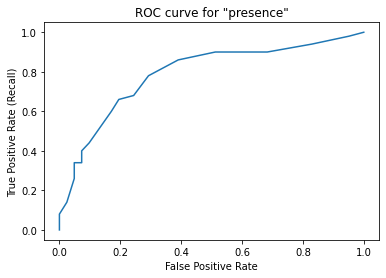

In [17]:
# Plot ROC curve
plt.plot(fpr, tpr, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title('ROC curve for "presence"')
plt.show()

Ideally, we would like to have a curve close to the upper left corner of the plot with a high recall and a small false positive rate. A way to quantify how close our curve is to that ideal one is to compute the “area” under our ROC curve (AUC)



In [18]:
from sklearn.metrics import roc_auc_score

# Area under the curve (AUC)
roc_auc_score(y_true=y_te, y_score=y_te_probs[:, 1])

0.7887804878048781

In our case, we have an AUC around 0.79

Let’s get back to the table and see how we can adapt the threshold to achieve a recall score of 90%. By looking at the second column, we see that the first recall score above 90% is row 21: by setting the threshold to 20%, we should get a recall of 92% - let’s verify this with code!

In [19]:
# Adjust threshold
custom_preds = ["absence" if p else "presence" for p in (y_te_probs[:, 1] < 0.2)]

print(classification_report(y_true=y_te, y_pred=custom_preds))

              precision    recall  f1-score   support

     absence       0.77      0.41      0.54        41
    presence       0.65      0.90      0.76        50

    accuracy                           0.68        91
   macro avg       0.71      0.66      0.65        91
weighted avg       0.71      0.68      0.66        91



In this code, we make predictions based on this new probability threshold and print the classification report. As we can see, the recall value when the positive class is presence is now 90% with a precision (i.e. How many times are we correct when we predict presence) of 65%.